In [ ]:
!pip install -q --upgrade keras-nlp tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 24.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.2 which is incompatible.


# Сборный проект-4

Вы работаете в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).

### Цель работы
Разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

<a id='id_1'></a>
### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Обзор и исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import torch
import tensorflow as tf
import keras_nlp

from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from transformers import AutoTokenizer, AutoModel
from tqdm import notebook
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, minmax_scale

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

Загрузим датасет.

In [ ]:
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

DATA_PATH = '/content/to_upload'

In [ ]:
df_train = pd.read_csv(Path(DATA_PATH, 'train_dataset.csv'))

In [ ]:
df_train.info()
df_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  
5  A young child is wearing blue goggles and sitt...  
6  A young child is wearing blue goggles and sitt...  
7  A young child is wearing blue goggles and sitt...  
8  A young child is wearing blue goggles and sitt...  
9  A young child is wearing blue goggles and sitt...

In [ ]:
for i in df_train.columns:
    print(i, df_train[i].nunique())

image 1000
query_id 977
query_text 977


Обучающий датасет состоит из 5822-х строк, пропуски отсутствуют, при этом уникальных изображений всего 1000, а запросов - 977.

In [ ]:
df_test = pd.read_csv(Path(DATA_PATH, 'test_queries.csv'), index_col=[0], sep='|')

In [ ]:
df_test.info()
df_test.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   
5  1232148178_4f45cc3284.jpg#0   
6  1232148178_4f45cc3284.jpg#1   
7  1232148178_4f45cc3284.jpg#2   
8  1232148178_4f45cc3284.jpg#3   
9  1232148178_4f45cc3284.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   
5                    A baby girl playing at a park .   
6  A closeup of a child on a playground with adul...   
7  A young boy poses for a picture in front of a ...   
8  A young girl is smiling in front of the camera...   
9  There is a little blond hair girl with a green...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg  
5  1232148178_4f45cc3284.jpg  
6  1232148178_4f45cc3284.jpg  
7  1232148178_4f45cc3284.jpg  
8  1232148178_4f45cc3284.jpg  
9  1232148178_4f45cc3284.jpg

In [ ]:
for i in df_test.columns:
    print(i, df_test[i].nunique())

query_id 500
query_text 500
image 100


Имеем 500 тестовых запросов, пропуски отсутствуют, при этом уникальных изображений всего 100.

Посмотрим на представленные изображения.

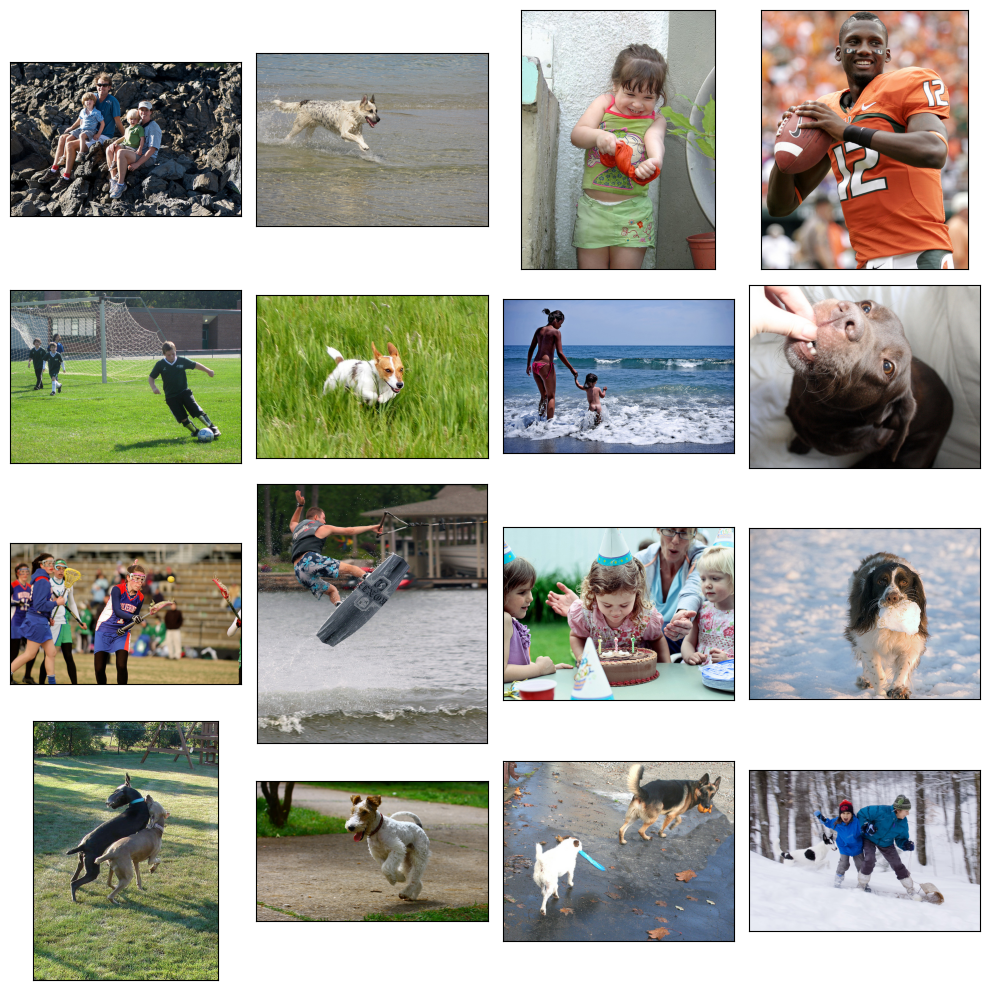

In [ ]:
samples_train = list(df_train['image'].sample(8))
samples_test = list(df_test['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(DATA_PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(DATA_PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Представлено большое разнообразие изображений, в том числе и попадающие под юридические ограничения в некоторых странах.

In [ ]:
test_images = pd.read_csv(Path(DATA_PATH, 'test_images.csv'))

In [ ]:
df_crowd = pd.read_csv(Path(DATA_PATH, 'CrowdAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'fraction', 'true_count', 'false_count'])
df_crowd.info()
df_crowd.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   fraction     47830 non-null  float64
 3   true_count   47830 non-null  int64  
 4   false_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


image                     query_id  fraction  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.000000   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.000000   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.000000   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.000000   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.000000   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2  0.000000   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2  0.000000   
7  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2  0.333333   
8  1056338697_4f7d7ce270.jpg  2307118114_c258e3a47e.jpg#2  0.000000   
9  1056338697_4f7d7ce270.jpg  2309860995_c2e2a0feeb.jpg#2  0.000000   

   true_count  false_count  
0           3            0  
1           0            3  
2           0            3  
3           0            3  
4           0            3  
5           0            3  
6           0            3  
7           1            2  
8           0            3  
9           0            3

Краудсорсинговый датасет состоит из 47830-ти строк, пропуски отсутствуют.

In [ ]:
df_crowd['fraction'].value_counts().to_frame().style.background_gradient('Reds')

Видим, что в данных преобладает доля исполнителей, подтвердивших, что текст соответствует картинке, равная нулю. На таких данных модель может обучиться плохо. Поэтому будем использовать только мнения экспертов.

In [ ]:
df_expert = pd.read_csv(Path(DATA_PATH, 'ExpertAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'first', 'second', 'third'])
df_expert.info()
df_expert.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2      1       1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2      1       1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2      1       1   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2      1       1   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2      2       2   

   third  
0      1  
1      2  
2      2  
3      2  
4      2  
5      1  
6      1  
7      2  
8      1  
9      2

Экспертный датасет состоит из 5822-х строк, пропуски отсутствуют.

Обработаем оценки экспертов. Если все три числа разные, то возьмем среднее значение округленное до целого числа, иначе - выберем голосованием по большинству. Сразу выполним преобразование к диапазону от 0 до 1.

In [ ]:
def expert_agg(row):
    if row['first'] != row['second'] != row['third']:
        row['score'] = int(row['first'] + row['second'] + row['third']) / 3 / 3
    else:
        row['score'] = (int(pd.Series([row['first'], row['second'], row['third']]).mode()) - 1) / 3
    return row

In [ ]:
df_expert = df_expert.apply(expert_agg, axis=1)

Столбец `score` в диапазоне от 0 до 1 теперь является целевым для нашего набора данных. Добавим его в тренировочный датафрейм.

In [ ]:
df_train = pd.merge(df_train, df_expert[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])

In [ ]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   query_text  5822 non-null   object 
 3   score       5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 182.1+ KB


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text     score  
0  A young child is wearing blue goggles and sitt...  0.000000  
1  A young child is wearing blue goggles and sitt...  0.000000  
2  A young child is wearing blue goggles and sitt...  0.333333  
3  A young child is wearing blue goggles and sitt...  1.000000  
4  A young child is wearing blue goggles and sitt...  0.000000

### Вывод по первому шагу
Выполнили обзор представленных данных, обнаружили, что на 5822 тренировочных изображений приходится 1000 уникальных, на 500 тестовых - 100 уникальных. Данные с изображениями отличаются большим разнообразием в том числе присутствуют изображения, попадающие под юридические ограничения в некоторых странах.

Рассмотрели разметку данных выполненную краудфайндерами и экспертами. В данных крауда преобладает доля исполнителей, подтвердивших, что текст соответствует картинке, равная нулю. На таких данных модель, вероятно, обучится плохо. Поэтому будем использовать только мнения экспертов. Оценку трех экспертов, в свою очередь, преобразовали в одну агрегированную оценку и добавили её к тренировочному датафрейму.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Создадим список слов, которые могут попадать под юридические ограничения.

In [ ]:
law_stopwords = [
    "child",
    "children",
    "kid",
    "kids",
    "baby",
    "babies",
    "boy",
    "boys",
    "girl",
    "girls",
    "teen",
    "teens",
    "teenage",
    "teenager",
    "teenagers",
    "infant",
    "infants",
    "youngster",
    "youngsters",
]

Сделаем маску для нашего набора данных, слова, запросы со словами, попадающими под ограничения, где id запроса соответствует изображению, пометим 1, остальные - 0.

In [ ]:
def mask(row):
    for word in row['query_text'].split(' '):
        if (word in law_stopwords) & (row['query_id'][:-2] == row['image']):
            row['mask'] = 1
            break
        else:
            row['mask'] = 0
    return row

In [ ]:
df_train = df_train.apply(mask, axis=1)
df_train.head(10)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text     score  mask  
0  A young child is wearing blue goggles and sitt...  0.000000     0  
1  A young child is wearing blue goggles and sitt...  0.000000     0  
2  A young child is wearing blue goggles and sitt...  0.333333     0  
3  A young child is wearing blue goggles and sitt...  1.000000     1  
4  A young child is wearing blue goggles and sitt...  0.000000     0  
5  A young child is wearing blue goggles and sitt...  0.333333     0  
6  A young child is wearing blue goggles and sitt...  0.000000     0  
7  A young child is wearing blue goggles and sitt...  0.000000     0  
8  A young child is wearing blue goggles and sitt...  0.000000     0  
9  A young child is wearing blue goggles and sitt...  0.000000     0

Посмотрим, как наша разметка справилась с задачей.

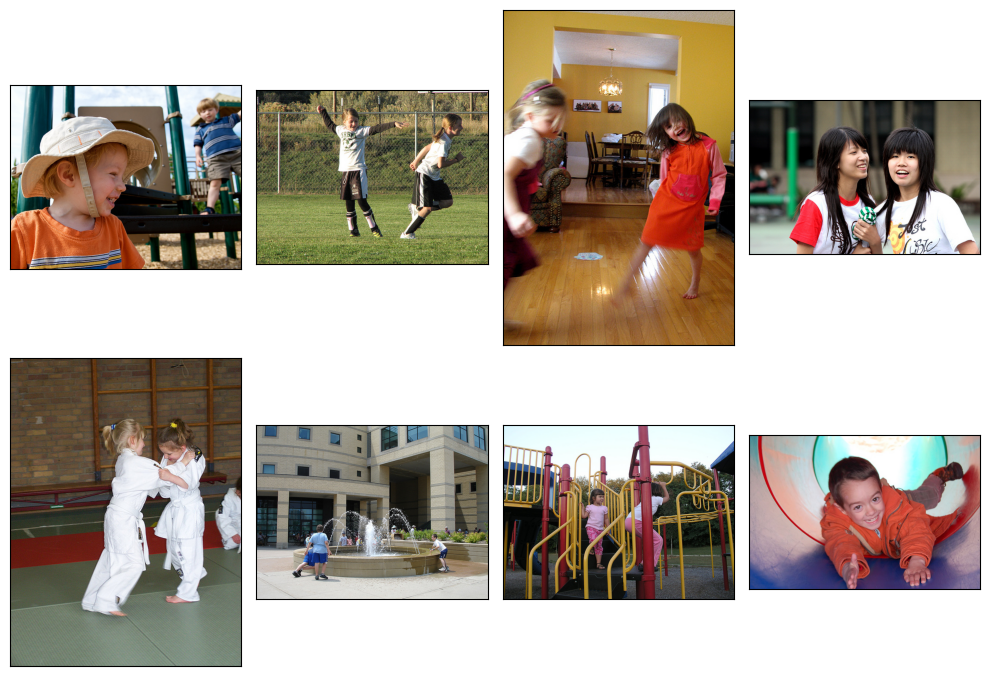

In [ ]:
samples_train = list(df_train[df_train['mask'] == 1]['query_id'].sample(8))
samples_train = [i[:-2] for i in samples_train]

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(2, 4, i+1)
    image = Image.open(Path(DATA_PATH, 'train_images/', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Видим, что разметка неплохо справилась со  своей задачей, определив детей на фотографиях. Далее удалим строки с меткой 1 и сам столбец с метками, т.к. далее он нам не нужен.

In [ ]:
df_train = df_train.query('mask == 0')
df_train = df_train.drop('mask', axis=1).reset_index(drop=True)

In [ ]:
df_train.info()
df_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5787 entries, 0 to 5786
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5787 non-null   object 
 1   query_id    5787 non-null   object 
 2   query_text  5787 non-null   object 
 3   score       5787 non-null   float64
dtypes: float64(1), object(3)
memory usage: 181.0+ KB


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
4  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
5  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
6  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
7   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
8  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
9  3741827382_71e93298d0.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text     score  
0  A young child is wearing blue goggles and sitt...  0.000000  
1  A young child is wearing blue goggles and sitt...  0.000000  
2  A young child is wearing blue goggles and sitt...  0.333333  
3  A young child is wearing blue goggles and sitt...  0.000000  
4  A young child is wearing blue goggles and sitt...  0.333333  
5  A young child is wearing blue goggles and sitt...  0.000000  
6  A young child is wearing blue goggles and sitt...  0.000000  
7  A young child is wearing blue goggles and sitt...  0.000000  
8  A young child is wearing blue goggles and sitt...  0.000000  
9  A young child is wearing blue goggles and sitt...  0.333333

### Вывод по второму шагу
Задали список слов, которые могут попадать под юридические ограничения. Создали алгоритм, который позволил отфильтровать запросы с запретными словами. Исключили из обучения все описания содержащие запрещённую информацию. Перейдём к векторизации изображений.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Напишем функцию для загрузки изображений.

In [ ]:
def load_train(path):
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=path,
        x_col='image',
        y_col='score',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=99)

    return train_gen_flow

In [ ]:
path = Path(DATA_PATH, 'train_images')
features, target = next(load_train(path))

Found 5787 validated image filenames.


Загрузчик нашел 5787 валидированных названий изображений.

Рассмотрим размерность признаков.

In [ ]:
features.shape

(16, 224, 224, 3)

Получились признаки — четырёхмерный тензор, в котором 16 изображений размером 224x224 с тремя цветовыми каналами.

Далее напишем функцию для модели. Т.к. у нас стоит задача только векторизовать изображения, последний, предсказывающий, слой `Dense` исключим.

In [ ]:
def create_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    optimizer = Adam(learning_rate = 0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

После чего напишем функцию для превращения картинок в вектор и выполним ее.

In [ ]:
def vectorize_pic(model, df_train):
    preds = model.predict(df_train)
    return preds

In [ ]:
vec_pics = vectorize_pic(create_model(), load_train(path))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Found 5787 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


362/362 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step


In [ ]:
vec_pics.shape

(5787, 2048)

Получили двумерный массив размером 5787 на 2048.

### Вывод по третьему шагу
Нам удалось провести векторизацию изображений с применением нейросети ResNet50. На выходе получили двумерный массив размером 5787 на 2048. Далее можем перейти к векторизации текстов.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Для текстов воспользуемся предобученным англоязычным берт-трансформером.

In [ ]:
# Загрузим трансформер Bert и предпрцессор для него
tokenizer = keras_nlp.models.BertBackbone.from_preset('bert_base_en')
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

100%|██████████| 510/510 [00:00<00:00, 348kB/s]
100%|██████████| 414M/414M [00:14<00:00, 30.2MB/s]
100%|██████████| 548/548 [00:00<00:00, 355kB/s]
100%|██████████| 208k/208k [00:00<00:00, 679kB/s]


После чего закодируем наш текст с помощью токенизатора,  приведем длину текстов в корпусе к единой(максимальной из всех имеющихся в наборе) длине.

In [ ]:
def vectorize_text(model, data, batch_size, preprocessor=preprocessor, bar=True, verbose=0):
    tokenized = preprocessor(data)

    embeddings = []
    if bar:
        for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size)):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    else:
        for i in range(tokenized['token_ids'].shape[0] // batch_size):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])
    return np.concatenate(embeddings)

In [ ]:
features_text = vectorize_text(model=tokenizer, data=df_train['query_text'], batch_size=9)

  0%|          | 0/643 [00:00<?, ?it/s]

In [ ]:
features_text.shape

(5787, 768)

Получили двумерный массив размером 5787 на 768.



### Вывод по четвертому шагу
Мы загрузили модель BERT base cased EN и получили эмбеддинги наших текстов. На выходе получили двумерный массив размером 5787 на 768. Теперь перейдем к объединению получившихся векторов.

## 5. Объединение векторов

Объединим векторы изображений и векторы текстов.

In [ ]:
X = np.concatenate((vec_pics, features_text), axis=1)

Зададим целевой признак.

In [ ]:
y = np.array(df_train['score'])

Посмотрим размерности получившихся наборов признаков.

In [ ]:
X.shape, y.shape

((5787, 2816), (5787,))

### Вывод по пятому шагу
По итогам конкотенации двух векторных представлений для фичей получили двумерный массив размером 5787 на 2816, для таргета - вектор длиной 5787.

## 6. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, воспользуемся классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и валидационную выборки в пропорции 8:2 так, что строки с одинаковым значением 'group_column' будут содержаться либо в валидационном, либо в тренировочном датасете.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=99)
train_indices, valid_indices = next(gss.split(
    X=X,
    y=y,
    groups=df_train['image']))
X_train, X_valid = X[train_indices], X[valid_indices]
y_train, y_valid = y[train_indices], y[valid_indices]

In [ ]:
X_train.min(), X_train.max(), X_train.mean()

(-1.0, 31.725134, 0.41572222)

Данные необходимо отмасштабировать.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

В качестве линейной модели используем линейную регрессию с L2 регуляризацией - Ridge.

Т.к. перед нами стоит задача регрессии, за метрику примем `RMSE`.

In [ ]:
linear_model = Ridge(alpha=500)

In [ ]:
linear_model.fit(X_train, y_train)

Ridge(alpha=500)

Посмотрим, как модель покажет себя на валидационных данных.

In [ ]:
preds = linear_model.predict(X_valid)
(mean_squared_error(y_valid, preds) ** 0.5).round(decimals=3)

0.3

Далее рассмотрим нейронную сеть.

In [ ]:
nn = Sequential()
nn.add(Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'))
nn.add(Dropout(0.2))
nn.add(BatchNormalization())
nn.add(Dense(512, activation='relu'))
nn.add(Dropout(0.3))
nn.add(BatchNormalization())
nn.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=0.0001)

nn.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

nn.build()

nn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2816)                │       7,932,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2816)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2816)                │          11,264 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │       1,442,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,388,801 (35.82 MB)

 Trainable params: 9,382,145 (35.79 MB)

 Non-trainable params: 6,656 (26.00 KB)

In [ ]:
nn.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256, epochs=1500,
    verbose=2, shuffle=True
    )

Epoch 1/1500
18/18 - 11s - 629ms/step - loss: 0.5989 - root_mean_squared_error: 0.9659 - val_loss: 0.4660 - val_root_mean_squared_error: 0.7597
Epoch 2/1500
18/18 - 0s - 10ms/step - loss: 0.5181 - root_mean_squared_error: 0.8468 - val_loss: 0.2626 - val_root_mean_squared_error: 0.4063
Epoch 3/1500
18/18 - 0s - 9ms/step - loss: 0.4450 - root_mean_squared_error: 0.7217 - val_loss: 0.2472 - val_root_mean_squared_error: 0.3995
Epoch 4/1500
18/18 - 0s - 16ms/step - loss: 0.4024 - root_mean_squared_error: 0.6579 - val_loss: 0.2427 - val_root_mean_squared_error: 0.4017
Epoch 5/1500
18/18 - 0s - 9ms/step - loss: 0.3635 - root_mean_squared_error: 0.6098 - val_loss: 0.2262 - val_root_mean_squared_error: 0.3701
Epoch 6/1500
18/18 - 0s - 9ms/step - loss: 0.3490 - root_mean_squared_error: 0.5763 - val_loss: 0.2251 - val_root_mean_squared_error: 0.3683
Epoch 7/1500
18/18 - 0s - 16ms/step - loss: 0.3204 - root_mean_squared_error: 0.5388 - val_loss: 0.2294 - val_root_mean_squared_error: 0.3709
Epoch 8

Модель линейной регресси и нейронная сеть показали примерно одинаковые результаты. Для тестирования выберем модель нейронной сети.

### Вывод по шестому шагу
 Разделили данные на обучающие и тестовые, провели обучение и тестирование двух моделей: линейной регрессии и нейронной сети, которые показали примерно одинаковые результаты. Для тестирования выберем модель неросети, с `RMSE` на валидационной выборке равным 0.3.

## 7. Тестирование модели

Настало время протестировать модель. Напишем функцию для загрузки тестовых данных.

In [ ]:
def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=path,
        x_col='image',
        y_col=None,
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=99)

    return test_gen_flow

Получим эмбеддинги для всех тестовых изображений из папки `test_images`.

In [ ]:
path_test = Path(DATA_PATH, 'test_images')
test_pics_embeds = vectorize_pic(create_model(), load_test(path_test))

Found 500 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step


Выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Все это сделаем в виде функции.

In [ ]:
def image_by_query(query):
    if [i for i in query.split(' ') if i in law_stopwords]:
        print()
        print('-' * 20, query, '-' * 20)
        print()
        print('This image is unavailable in your country in compliance with local laws.')
        print()
    else:
        features_text = vectorize_text(model=tokenizer, data=[query], bar=False, batch_size=1)
        embed_text = np.resize(features_text, (test_pics_embeds.shape[0], 768))
        X = np.concatenate((test_pics_embeds, embed_text), axis=1)
        preds = linear_model.predict(X)
        image_preds = pd.concat(
            (test_images,
             pd.Series(data=[query for i in range(len(test_images))], name='query'),
             pd.Series(data=preds.flatten(), name='preds')), axis=1).dropna()
        top = list(image_preds.sort_values(by='preds', ascending=False)['image'].head(1))
        top_score = list(image_preds.sort_values(by='preds', ascending=False)['preds'].head(1))

        print()
        print('-' * 15, query, '-' * 15)
        print()

        fig = plt.figure(figsize=(10,3))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0

        fig.add_subplot(1, 2, 1, title=round(*top_score, 2))
        image = Image.open(Path(DATA_PATH, "test_images", *top))
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

        fig = plt.figure(figsize=(2,2))
        plt.rcParams['axes.edgecolor'] = 'green'
        plt.rcParams['axes.linewidth'] = 5
        image = Image.open(
            Path(DATA_PATH, "test_images",
            df_test.iloc[df_test[df_test["query_text"] == query].index[0]]['image'])
            )
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        print()

        plt.show()



-------------------- A boy in blue is riding his bike in a skate park . --------------------

This image is unavailable in your country in compliance with local laws.


--------------- A group of people gather on the grass field and throw a pink hoop . ---------------



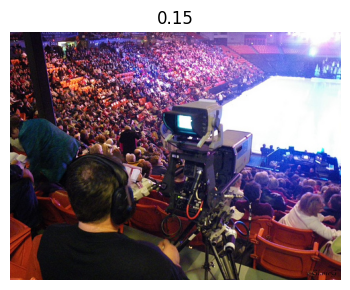

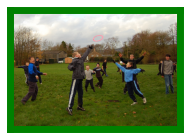


--------------- Grey horse wearing blue cover eating from a orange bucket held by a person in a green shirt . ---------------



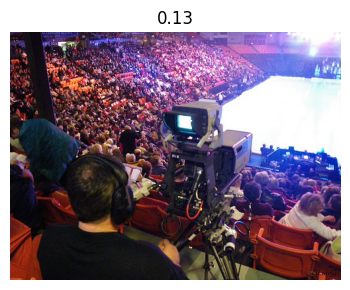

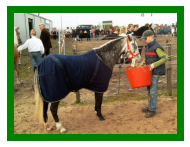


-------------------- A little girl with a purple fuzzy hat is riding a tricycle outside . --------------------

This image is unavailable in your country in compliance with local laws.


--------------- Man rides on bicycle as other people walk . ---------------



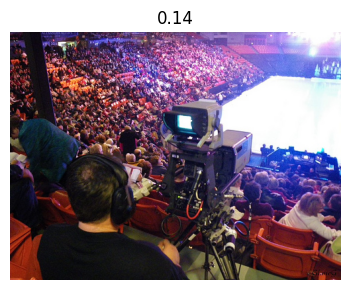

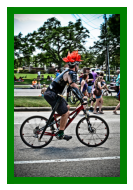


--------------- Costumed performers stand onstage with their arms outstretched . ---------------



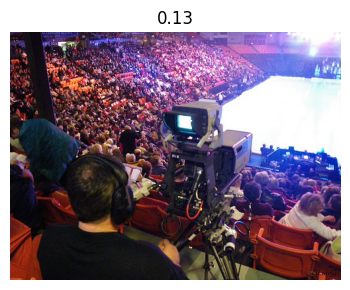

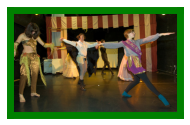


--------------- a biker rides down the street . ---------------



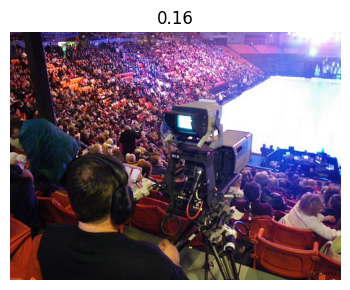

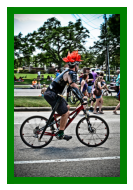


--------------- a family standing in a rock cave with some of their belongings in the background ---------------



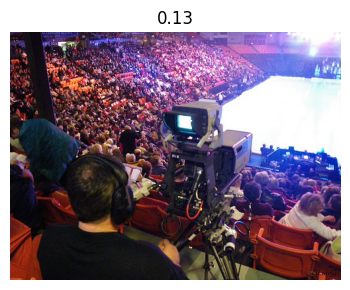

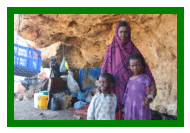


-------------------- A baby holds a game control above its head and laughs . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- Two boys in swimsuits standing under running water . --------------------

This image is unavailable in your country in compliance with local laws.



In [ ]:
test_sample = df_test.sample(10)
text_test = list(test_sample['query_text'])
for query in text_test:
    image_by_query(query)

### Вывод по седьмому шагу
Написали функцию, которая выводит лучшую модель с предсказанием и действительное изображение по описанию. Визуально оценили работу модели. Качество её работы неудовлетварительно, т.к. лишь в некоторых случаях картинки связаны тематически, но точное попадание отсутствует.

## 8. Общий вывод

Выполнили обзор представленных данных, обнаружили, что на 5822 тренировочных изображений приходится 1000 уникальных, на 500 тестовых - 100 уникальных. Данные с изображениями отличаются большим разнообразием в том числе присутствуют изображения, попадающие под юридические ограничения в некоторых странах.

Рассмотрели разметку данных выполненную краудфайндерами и экспертами. В данных крауда преобладает доля исполнителей, подтвердивших, что текст соответствует картинке, равная нулю. На таких данных модель, вероятно, обучится плохо. Поэтому будем использовать только мнения экспертов, во-первых, потому что их профессиональное мнение само по себе несет большую ценность, во-вторых, потому что набор данных имеет шкалу соответствия картинки и текста, что может помочь при обучении модели. Поэтому трансформировали оценку трех экспертов в одну агрегированную оценку и добавили её к тренировочному датафрейму.

Задали список слов, которые могут попадать под юридические ограничения. Лемматизировали и очистили текстовые запросы. Создали алгоритм, который позволил отфильтровать запросы с запретными словами. Тем самым сформировали окончательный набор тренировочных данных, состоящий из 5787-ех строк.

Далее выполнили векторизацию изображений средствами библиотеки `Keras`. На выходе получили двумерный массив размером 5787 на 2048.

После чего выполнили векторизацию текстовых запросов при помощи трансформера `Bert`. На выходе получили двумерный массив размером 5787 на 768.

Затем выполнили объединение векторов текстовых запросов и изображений. Для фичей получили двумерный массив размером 5787 на 2816, для таргета - вектор длиной 5787.

Разделили данные на обучающие и тестовые, провели обучение и тестирование двух моделей: линейной регрессии с L2 регуляризацией и нейронной сети, которые показали примерно одинаковые результаты. Для тестирования выберем модель неросети, с `RMSE` на валидационной выборке равным 0.3.

Написали функцию, которая выводит лучшую модель с предсказанием и действительное изображение по описанию. Визуально оценили работу модели. Качество её работы неудовлетварительно, т.к. лишь в некоторых случаях картинки связаны тематически, но точное попадание отсутствует. Вероятно, для решения данной задачи стоит использовать современные нейронные сети, предназначенные именно для поиска изображений по текстовому описанию.

## 9. Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска